In [200]:
import numpy as np
import scipy.stats as ss
from scipy.spatial import distance_matrix
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import SpectralClustering
from tqdm import tqdm

# Random "gene" sequence generation

In [211]:
N=1000
heterozygosity = 0.045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

snp_positions = np.sort(random.sample(range(N),round(N*heterozygosity))) # [loc for i in range(round(N*heterozygosity))]
sequence = "".join(np.random.choice(list(alphabet.keys()), N))

print(f"Uniformly selected SNP loci:\n{snp_positions}")
print(f"\nReference sequence of randomly generated gene sequence:\n{sequence}")

Uniformly selected SNP loci:
[ 13  32  39  56  73  89 102 116 125 154 155 182 191 272 299 302 322 329
 335 381 417 439 484 541 584 597 600 623 627 652 743 768 781 838 842 845
 865 878 909 933 956 968 981 982 988]

Reference sequence of randomly generated gene sequence:
AACGCAACCGTTCGTGGCCCTGGGCATGGATGAGAAGAAGGCTATCATCTAGGCCCATCGAGGGGCGGGGAACAGAATCCAGCCCCCGCTGCATCGGTAAGACTCTGGTGGAGCTTCATAAAATACAGGTTGGACCCCTGATCCATCACACGCTGTCCCTTTTTCTTTTCCGCGGGGATACGTTGTCTTGGACGCCGTTTCCACACACAATGAATTAGCAGTAGGAGAACAACCCTGACGCTGCACCCCCTCGGATATTGAATGTGGTCACCAAATATGCTATAGCGACGGACGTAAATGATCGTCCGAGCCGCTCCGATCACGAGGCACACCCAAGGACCCTCGTTCTCGGTCATTTTTATTCTGATGTTAAATGCACGATAGGCCGCGACTAACAAGCAGACAATGGCGACAGTAAGGACATCCCACTTGATAACGCAGTTTACCTTTGGCCGGATTCAAAGCCATGACTGGGGATGCATCAAAGCACACCAACGGGAGACACGAACCCAGACTTTCGGACGATCCCTATAAAAGCAGGATCGACATAATGTCGTAACTCCGCACGTCAATTTATCCCCGCGTGATGAAGAGCCAAGCCTCTCAAAGCAGCATCCTGAACAGACCAAGACTACGACATGCCTAGTGTCCTTAGTCCGATGAGTTCGCCATATCGCTTTCTGCGTTGGAGTTCGCTCGACGACACTCACGTTGGGTCCTAACGATCAAT

# Simulating scRNA-seq reads

In [212]:
class EmbryoSequenceSimulator:
    def __init__(self, references, snps, n_embryos):
        self.references = references # map gene->sequence
        self.snps = snps # map gene->list of snp locations
        self.n_embryos = n_embryos
        
        # Number of cells that can be harvested from embryo
        self.n_cells = round(np.random.normal(100, 10))
        self.alphabet = {"A":0, "C":1, "G":2, "T":3}

    def pooled_snp_profile_simulation(self):
        profile = []
        for _ in range(self.n_embryos):
            snp_profile = []
            for gene in self.references.keys():
                sequence = self.references[gene]
                snp_positions = self.snps[gene]
                m_chromatid,p_chromatid = self.embryo_sequence_simulation(sequence, snp_positions)
                for locus in snp_positions:
                    genotype = "".join([m_chromatid[locus],p_chromatid[locus]])
                    snp_profile.append(genotypes[genotype])
            for __ in range(self.n_cells):
                profile.append(snp_profile)
        return profile

    def embryo_sequence_simulation(self, reference, snp_positions):

        # Seeding parental chromatids
        parental_seqs = self.parental_seeding(reference, snp_positions)

        # Homologous recombination
        m0,m1 = self.homologous_recombination(parental_seqs["m0"],parental_seqs["m1"])
        p0,p1 = self.homologous_recombination(parental_seqs["p0"],parental_seqs["p1"])

        # Choose pairs of parental chromatids that get inherited by embryo
        m_chromatid = m0 if random.random() <= 0.5 else m1
        p_chromatid = p0 if random.random() <= 0.5 else p1

        return m_chromatid, p_chromatid

    def parental_seeding(self, reference, snp_positions):
        sequences = {}
        for parent in ["m0", "m1", "p0", "p1"]: # m = maternal; p = paternal
            # key: position; value: random nucleotide
            snp_profile = {locus:random.choice(list(self.alphabet.keys())) for locus in snp_positions}
            sequence = [char for char in reference]
            for locus,char in snp_profile.items():
                sequence[locus] = char
            sequences[parent] = "".join(sequence)
        return sequences

    def homologous_recombination(self, c0, c1): # c for chromatid
        chiasma_point = random.choice(range(len(c0)))

        # Maybe not necessary, but intent is that either top or bottom half can cross over 
        if random.random() <= 0.5:
            updated_c0 = c0[:chiasma_point]+c1[chiasma_point:]
            updated_c1 = c1[:chiasma_point]+c0[chiasma_point:]
        else:
            updated_c0 = c1[:chiasma_point]+c0[chiasma_point:]
            updated_c1 = c0[:chiasma_point]+c1[chiasma_point:]

        return updated_c0, updated_c1        


# Processing sequences to get input X

In [213]:
heterozygosity = 0.045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

In [219]:
# Model for multiple genes
sequences = {} # key: gene/contig identifer;  value: nucleotide sequence
snps = {}      # key: gene/contig identifier; value: list of snp locations

for gene in ["gene1", "gene2"]:
    N = round(np.random.normal(1000, 250)) # gene length
    snps[gene] = np.sort(random.sample(range(N),round(N*heterozygosity))) # [loc for i in range(round(N*heterozygosity))]
    sequences[gene] = "".join(np.random.choice(list(alphabet.keys()), N))

n_embryos = 10
simulator = EmbryoSequenceSimulator(sequences,snps,n_embryos)
profile = simulator.pooled_snp_profile_simulation()
X = np.array(profile)
print(X.shape)
print(X)

(1320, 86)
[[9 1 0 ... 3 0 2]
 [9 1 0 ... 3 0 2]
 [9 1 0 ... 3 0 2]
 ...
 [3 3 1 ... 5 1 4]
 [3 3 1 ... 5 1 4]
 [3 3 1 ... 5 1 4]]


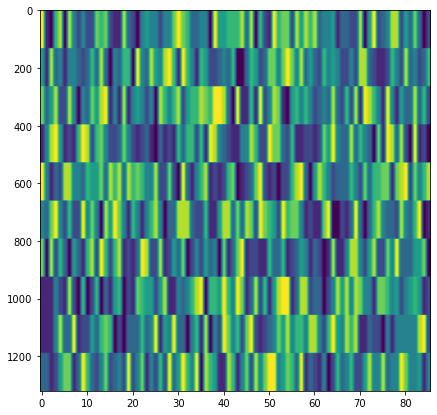

In [220]:
fig,ax = plt.subplots(figsize=(7,7))
ax.imshow(X, aspect='auto')
plt.show()

# All-vs-all distance matrix

100%|██████████| 1320/1320 [00:42<00:00, 31.02it/s]


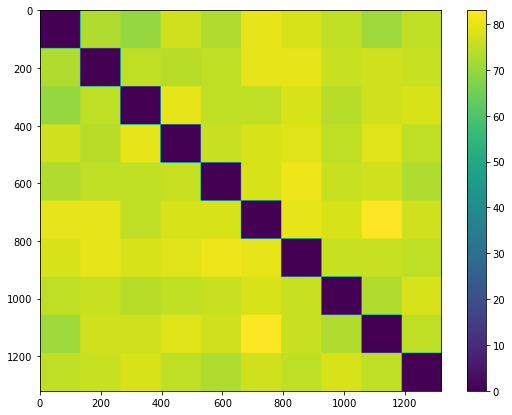

In [221]:
def hamming(g0, g1):
    n_mismatches = 0
    for i, j in zip(g0, g1):
        if i != j: n_mismatches += 1
    return n_mismatches

# Hamming distance all-vs-all matrix
distX = np.zeros((X.shape[0],X.shape[0]))
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[0]):
        distX[i,j] = hamming(X[i,:], X[j,:])

fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(distX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()

[[ 9  1 -1 ... -1  0  2]
 [ 9  1  0 ... -1  0  2]
 [ 9 -1  0 ...  3 -1 -1]
 ...
 [ 3  3  1 ...  5  1  4]
 [ 3  3  1 ...  5  1  4]
 [ 3  3  1 ...  5 -1  4]]


100%|██████████| 1320/1320 [01:22<00:00, 15.92it/s]


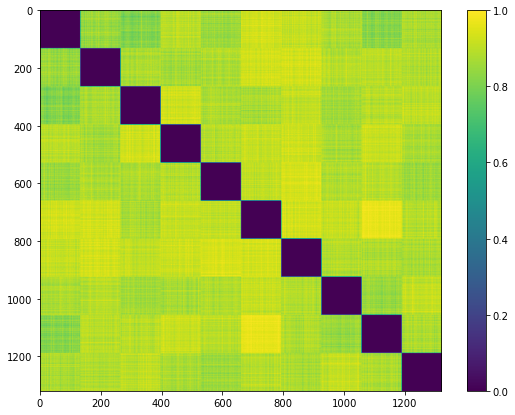

In [222]:
# Introduce uniform dropout
n,m = X.shape
dropoutX = np.copy(X)
dropout = 0.3
n,m = X.shape
for i in range(n):
    for j in range(m):
        if random.random() <= dropout:
            dropoutX[i,j] = -1

print(dropoutX)

def adjustedHamming(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Sequence lengths unequal.")
    else:
        adjSequenceLength, nNucleotideMismatch = 0, 0
        for i, j in zip(s1, s2):
            if i == -1 or j == -1: 
                continue
            adjSequenceLength += 1
            if i != j: 
                nNucleotideMismatch += 1
        return nNucleotideMismatch, adjSequenceLength

# Hamming distance all-vs-all matrix
hd = np.zeros((n,n))
adjlen = np.zeros((n,n))
for i in tqdm(range(n)):
    for j in range(n):
        adjusted_hamming,length = adjustedHamming(dropoutX[i,:], dropoutX[j,:])
        hd[i,j] = adjusted_hamming
        adjlen[i,j] = length

ddistX = np.divide(hd,adjlen)
fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(ddistX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()

In [209]:
# clustering = SpectralClustering(n_clusters=n_embryos, assign_labels="discretize").fit(X)
# print(clustering.labels_)
